In [ ]:
import pyvista as pv
import copy
import numpy as np 
import matplotlib.pyplot as plt

In [ ]:
class draw_grid:
    def __init__(self, grd):
        grid = copy.deepcopy(grd)
        self.grid = grid
        x_ind_min, y_ind_min, z_ind_min = 0, 0, 0
        Nx, Ny, Nz = self.grid.dimensions
        x_ind_max, y_ind_max, z_ind_max = Nx-1, Ny-1, Nz-1

        self.x_ind_min, self.y_ind_min, self.z_ind_min = x_ind_min, y_ind_min, z_ind_min
        self.x_ind_max, self.y_ind_max, self.z_ind_max = x_ind_max, y_ind_max, z_ind_max
        
        bottom_subset = (x_ind_min, x_ind_max, y_ind_min, y_ind_max, 0, 0)
        bottom = self.grid.extract_subset(bottom_subset).extract_surface()
        bottom.active_vectors_name = 'B'
        bottom.active_scalars_name = 'mag'

        self.bottom = bottom

        self.x_bottom = bottom.points[:, 0].reshape(Nx, Ny)
        self.y_bottom = bottom.points[:, 1].reshape(Nx, Ny)
        self.B_bottom = bottom['B'].reshape(Nx, Ny, 3)

        B = self.grid['B'].reshape(Nz, Ny, Nx, 3)
        self.B = B.transpose(2, 1, 0, 3)

    def plt_Bz(self):
        plt.close()
        fig, ax = plt.subplots(figsize=(6,6))
        CS = plt.contour(self.x_bottom, self.y_bottom, self.B_bottom[:, :, 2], 
                         origin='lower', colors='k')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.clabel(CS, fontsize=9, inline=True)
        ax.set_title(r"$B_z(z=0)$")
        plt.show()
    

    def k3d_bottom(self):
        p = pv.Plotter()
        p.show_bounds()
        p.add_mesh(self.grid.outline())
        p.add_mesh(self.bottom)
        p.show()

    def pv_bottom(self):
        p = pv.Plotter()
        p.show_bounds()
        p.add_mesh(self.grid.outline())
        p.add_mesh(self.bottom)
        p.show()

    def pv_Bz_2D(self):
        p = pv.Plotter()
        p.show_bounds()
        p.add_mesh(self.grid.outline())
        sargs = dict(title="B_z")
        ctr = self.bottom.contour(scalars=self.bottom['B'][:, 2])
        p.add_mesh(ctr, cmap='plasma', scalar_bar_args=sargs)
        p.show()

    def pv_Bz_3D(self):
        p = pv.Plotter()
        p.show_bounds()
        p.add_mesh(self.grid.outline())
        sargs = dict(title="B_z")
        ctr = self.grid.contour(scalars=self.grid['B'][:, 2])
        p.add_mesh(ctr, cmap='plasma', scalar_bar_args=sargs, opacity=0.5)
        p.show()

    def pv_streamline(self):
        p = pv.Plotter()
        p.show_bounds()
        p.add_mesh(self.grid.outline())
        i_size = self.grid.bounds[1]-self.grid.bounds[0]
        j_size = self.grid.bounds[3]-self.grid.bounds[2]
        seed = pv.Plane(center=(self.grid.center[0], self.grid.center[1], 0), direction=(0,0,1), 
                i_size=i_size, j_size=j_size, 
                i_resolution=10, j_resolution=10)
        p.add_mesh(seed)
        strl = self.grid.streamlines_from_source(seed,
                                                 vectors='B',
                                                 max_time=180,
                                                 initial_step_length=0.1,
                                                 integration_direction='both')
        
        p.add_mesh(strl.tube(radius=i_size/400), cmap='bwr', ambient=0.2)

        sargs = dict(title="B_z")
        ctr = self.bottom.contour(scalars=self.bottom['B'][:, 2])
        p.add_mesh(ctr, cmap='plasma', scalar_bar_args=sargs)
        p.show()

    def pv_streamline_Bz(self, window_size=None, title=None, title_fontsize=20, camera_position=None, i_siz=None, j_siz=None, i_resolution=10, j_resolution=10, vmin=-2000, vmax=2000):
        p = pv.Plotter()
        # p.show_bounds()
        p.add_mesh(self.grid.outline())
        sargs_B = dict(
            title='Bz [G]',
            title_font_size=15,
            height=0.25,
            width=0.05,
            vertical=True,
            position_x = 0.05,
            position_y = 0.05,
        )
        dargs_B = dict(
            scalars='B', 
            component=2, 
            clim=(vmin, vmax), 
            scalar_bar_args=sargs_B, 
            show_scalar_bar=True, 
            lighting=False
        )
        p.add_mesh(self.bottom, cmap='gray', **dargs_B)

        if (i_siz is not None) and (j_siz is not None):
            i_size = i_siz
            j_size = j_siz
        else:
            i_size = self.grid.bounds[1]-self.grid.bounds[0]
            j_size = self.grid.bounds[3]-self.grid.bounds[2]
        seed = pv.Plane(center=(self.grid.center[0], self.grid.center[1], 0), direction=(0,0,1), 
                i_size=i_size, j_size=j_size, 
                i_resolution=i_resolution, j_resolution=j_resolution)
        # p.add_mesh(seed)
        strl = self.grid.streamlines_from_source(seed,
                                                 vectors='B',
                                                 max_time=180,
                                                 initial_step_length=0.1,
                                                 integration_direction='both')
        
        p.add_mesh(strl.tube(radius=i_size/400), 
                   lighting=False,
                   color='blue')
        if camera_position is not None:
             p.camera_position = camera_position
        if window_size is not None:
            p.window_size = window_size
        if title is not None:
            p.add_title(title, font_size=title_fontsize)
        p.show()
        return p
    
    def create_mesh(self, i_siz=None, j_siz=None, i_resolution=10, j_resolution=10, vmin=-2000, vmax=2000):
        if (i_siz is not None) and (j_siz is not None):
            i_size = i_siz
            j_size = j_siz
        else:
            i_size = self.grid.bounds[1]-self.grid.bounds[0]
            j_size = self.grid.bounds[3]-self.grid.bounds[2]
        seed = pv.Plane(center=(self.grid.center[0], self.grid.center[1], 0), direction=(0,0,1), 
                i_size=i_size, j_size=j_size, 
                i_resolution=i_resolution, j_resolution=j_resolution)
        # p.add_mesh(seed)
        strl = self.grid.streamlines_from_source(seed,
                                                 vectors='B',
                                                 max_time=180,
                                                 initial_step_length=0.1,
                                                 integration_direction='both')
        
        sargs_B = dict(
            title='Bz [G]',
            title_font_size=15,
            height=0.25,
            width=0.05,
            vertical=True,
            position_x = 0.05,
            position_y = 0.05,
        )
        dargs_B = dict(
            scalars='B', 
            component=2, 
            clim=(vmin, vmax), 
            scalar_bar_args=sargs_B, 
            lighting=False
        )

        self.tube = strl.tube(radius=i_size/400)
        self.dargs_B = dargs_B        
        return strl.tube(radius=i_size/400), self.bottom, dargs_B


    def plt_Bz_imshow(self, z=0, vmin=None, vmax=None):         
        plt.close()
        fig, ax = plt.subplots(figsize=(6,6))
        if (vmin is not None) and (vmax is not None):
            CS = plt.imshow(self.B[:, :, z, 2].transpose(), origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
        else:
            CS = plt.imshow(self.B[:, :, z, 2].transpose(), origin='lower', cmap='gray')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(f"B_z(z={z})")
        fig.colorbar(CS)
        plt.show()

In [3]:
pv.set_jupyter_backend('static')

In [4]:
B_spinn_mesh = pv.read('03_eval/lowlou_300256128/SPINN/B_spinn.vtk')
B_spinn = draw_grid(B_spinn_mesh)

In [5]:
B_spinn.create_mesh(i_siz=None, j_siz=None, i_resolution=10, j_resolution=10, vmin=-50, vmax=100);

In [6]:
B_pinn_mesh = pv.read('03_eval/lowlou_300256128/PINN/B_pinn.vtk')
B_pinn = draw_grid(B_pinn_mesh)

In [7]:
B_pinn.create_mesh(i_siz=None, j_siz=None, i_resolution=10, j_resolution=10, vmin=-50, vmax=100);

In [8]:
def create_coordinates(bounds):
    xbounds = (bounds[0], bounds[1])
    ybounds = (bounds[2], bounds[3])
    zbounds = (bounds[4], bounds[5])
    meshgrid = np.mgrid[xbounds[0]:xbounds[1]+1, ybounds[0]:ybounds[1]+1, zbounds[0]:zbounds[1]+1]
    return np.stack(meshgrid, axis=-1).astype(np.float32)

In [9]:
b_mesh = pv.read('01_input/lowlou_300256128/b.vtk')
Nx, Ny, Nz = b_mesh.dimensions
co_bounds = (0, Nx-1, 0, Ny-1, 0, Nz-1)
co_coords = create_coordinates(co_bounds).reshape(-1, 3)
co_coord = co_coords.reshape(Nx, Ny, Nz, 3)
x = co_coord[..., 0]
y = co_coord[..., 1]
z = co_coord[..., 2]
mesh = pv.StructuredGrid(x, y, z)
mesh['B'] = b_mesh['B']
mesh.active_vectors_name = 'B'
mesh['mag'] = b_mesh['mag']
mesh.active_scalars_name = 'mag'
b = draw_grid(mesh)

In [10]:
b.create_mesh(i_siz=None, j_siz=None, i_resolution=10, j_resolution=10, vmin=-50, vmax=100);

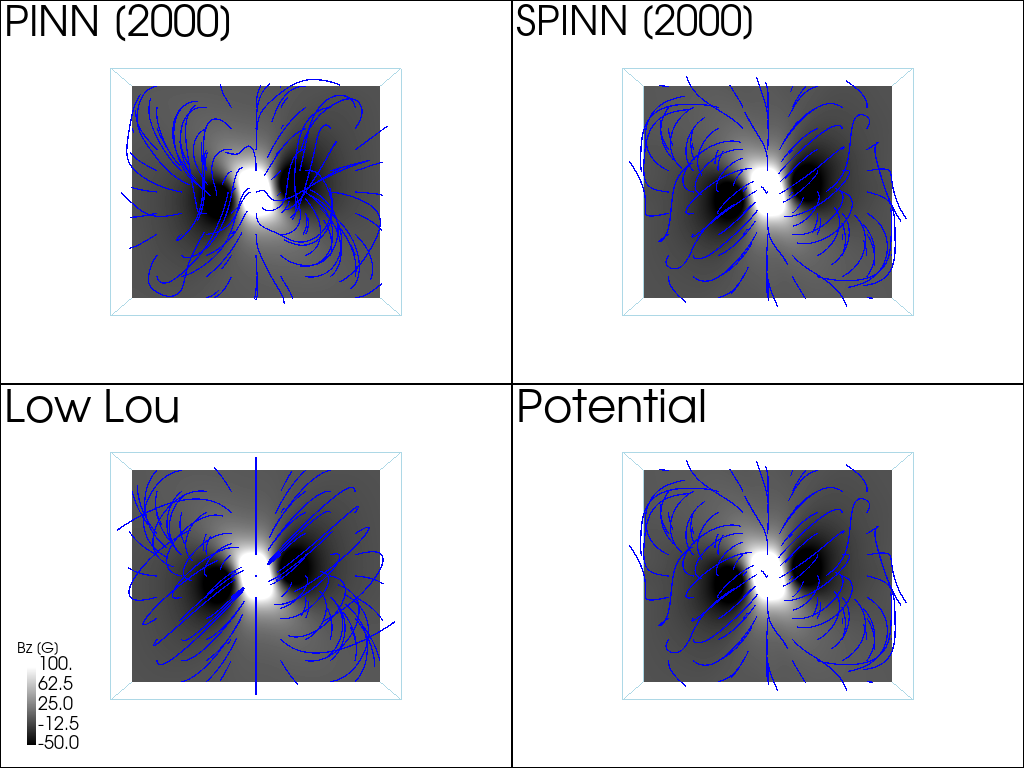

In [11]:
p = pv.Plotter(shape=(2,2))
p.subplot(0,0)
p.add_mesh(B_pinn.grid.outline())
p.add_mesh(B_pinn.bottom, cmap='gray', show_scalar_bar=False, **B_pinn.dargs_B)
p.add_mesh(B_pinn.tube, lighting=False, color='blue')
p.camera_position = 'xy'
p.add_text("PINN [2000]")

p.subplot(0,1)
p.add_mesh(B_spinn.grid.outline())
p.add_mesh(B_spinn.bottom, cmap='gray', show_scalar_bar=False, **B_spinn.dargs_B)
p.add_mesh(B_spinn.tube, lighting=False, color='blue')
p.camera_position = 'xy'
p.add_text("SPINN [2000]")

p.subplot(1,0)
p.add_mesh(b.grid.outline())
p.add_mesh(b.bottom, cmap='gray', show_scalar_bar=True, **b.dargs_B)
p.add_mesh(b.tube, lighting=False, color='blue')
p.camera_position = 'xy'
p.add_text("Low Lou")

p.subplot(1,1)
p.add_mesh(B_spinn.grid.outline())
p.add_mesh(B_spinn.bottom, cmap='gray', show_scalar_bar=False, **B_spinn.dargs_B)
p.add_mesh(B_spinn.tube, lighting=False, color='blue')
p.camera_position = 'xy'
p.add_text("Potential")

# p.window_size = (800, 600)
p.show()